# DESI Commissioning Weather Analysis

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import datetime

In [3]:
import pandas as pd

In [4]:
import desimodel.weather

## Dome Closed Fraction

Import [this spreadsheet](https://docs.google.com/spreadsheets/d/19a4i_ffxD9saup1O3-DJFDhqbS675JBMIp1QT7NQVXg/edit?usp=sharing) exported as a csv file:

In [5]:
actual = pd.read_csv('DomeClosedCI.csv')

Actual mean is 17.4%
Model mean is 16.4%
Worst year is 2009 with 23.5%
Best year is 2008 with 6.3%


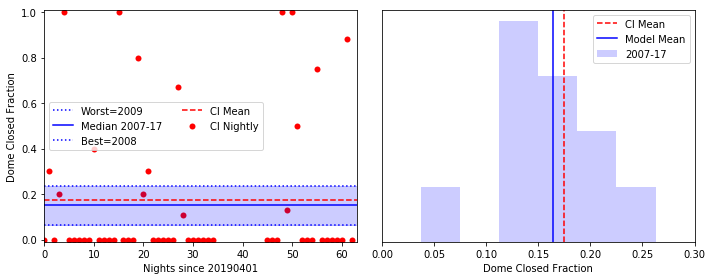

In [6]:
def plot_dome(df=actual):
    # Extract the actual weather history.
    actual_frac = df['Closed Frac']
    nights = pd.to_datetime(df['NIGHT'])
    first, last = nights.iloc[0].date(), nights.iloc[-1].date()
    dt = np.array([(night.date() - first).days for night in nights])
    last += datetime.timedelta(days=1)
    nnights = dt[-1] + 1
    assert nnights == (last - first).days
    print(f'Actual mean is {100 * actual_frac.mean():.1f}%')
    
    # Calculate the predicted dome-closed fraction for the nights of the CI run.
    cirun = np.zeros(nnights, bool)
    cirun[dt] = True
    nyears = 11
    model_frac = np.empty(nyears)
    years = range(2007, 2018)
    for i, year in enumerate(years):
        closed = desimodel.weather.dome_closed_fractions(first, last, replay='Y{}'.format(year))
        model_frac[i] = np.mean(closed[cirun])
    ilo, ihi = np.argmin(model_frac), np.argmax(model_frac)
    print(f'Model mean is {100 * model_frac.mean():.1f}%')
    print(f'Worst year is {years[ihi]} with {100 * model_frac[ihi]:.1f}%')
    print(f'Best year is {years[ilo]} with {100 * model_frac[ilo]:.1f}%')
    
    # Plot the actual and predicted dome-closed fraction.
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].axhspan(model_frac[ilo], model_frac[ihi], color='b', alpha=0.2)
    ax[0].axhline(model_frac[ihi], label=f'Worst={years[ihi]}', ls=':', c='b')
    ax[0].axhline(np.median(model_frac), label='Median 2007-17', c='b')
    ax[0].axhline(model_frac[ilo], label=f'Best={years[ilo]}', ls=':', c='b')
    ax[0].scatter(dt, actual_frac, c='r', lw=0, label='CI Nightly')
    ax[0].set_xlim(0, nnights)
    ax[0].set_ylim(-0.01, 1.01)
    ax[0].set_xlabel('Nights since 20190401')
    ax[0].set_ylabel('Dome Closed Fraction')
    ax[0].axhline(actual_frac.mean(), c='r', ls='--', label='CI Mean')
    ax[0].legend(loc='center left', ncol=2)

    ax[1].axvline(actual_frac.mean(), c='r', ls='--', label='CI Mean')
    ax[1].hist(model_frac, bins=np.linspace(0, 0.3, 9), histtype='stepfilled', alpha=0.2, color='b', label='2007-17')
    ax[1].axvline(model_frac.mean(), c='b', ls='-', label='Model Mean')
    ax[1].set_yticks([])
    ax[1].legend()
    ax[1].set_xlim(0., 0.3)
    ax[1].set_xlabel('Dome Closed Fraction')
    
    plt.tight_layout()
    plt.savefig('CIdome.pdf')
    
plot_dome()